#setup

In [ ]:
%%capture
!pip install transformers
!pip install shap

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
import pickle
import numpy as np
import pandas as pd
import random
from itertools import chain
import torch
import torch.nn.functional as F
import itertools
import heapq

import matplotlib.pyplot as plt
!apt-get install -y fonts-arial-regular
plt.rcParams["font.family"] = "Arial"

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package fonts-arial-regular


#load data

In [ ]:
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/final_files/'
datasets=['LIAR','Fake News', 'IMDB']
path_data_created_sets=['LIAR/','Fake News/','IMDB/']

df_del = {}
df_pres = {}
df_inc = {}
df_inc_add = {}

for i in range(len(datasets)):
    dataset = datasets[i]
    path_data_created_set = path_data_created_sets[i]
    df_del[dataset] = pd.read_csv(path_data_created+path_data_created_set+dataset+'_del.csv')
    df_pres[dataset] = pd.read_csv(path_data_created+path_data_created_set+dataset+'_pres.csv')
    df_inc[dataset] = pd.read_csv(path_data_created+path_data_created_set+dataset+'_inc.csv')
    df_inc_add[dataset] = pd.read_csv(path_data_created+path_data_created_set+dataset+'_inc_add.csv')



In [ ]:
for d in datasets:
  df_inc[d].to_latex((path_data_created+d+'/'+d+'_df_inc.tex'))

In [ ]:
df_inc_add['LIAR']


,Unnamed: 0,k,acc_selected,flip_selected,lor_change_selected,aopc_selected,acc_rand,flip_rand,lor_change_rand,aopc_rand
0,0,0.00,0.515,0.470,-6.729048,0.505416,0.515,0.470,-6.729048,0.505416
1,0,0.05,0.515,0.470,-6.742857,0.505457,0.514,0.469,-6.733334,0.506230
2,0,0.10,0.516,0.471,-6.745523,0.504610,0.516,0.471,-6.710441,0.504417
3,0,0.15,0.518,0.473,-6.683501,0.501528,0.515,0.470,-6.747610,0.505378
4,0,0.20,0.527,0.480,-6.566186,0.494399,0.516,0.471,-6.718365,0.504404
5,0,0.25,0.528,0.481,-6.562083,0.494161,0.519,0.472,-6.698509,0.503388
6,0,0.30,0.530,0.487,-6.446843,0.489354,0.518,0.471,-6.709208,0.504183
7,0,0.35,0.540,0.511,-6.068654,0.464570,0.522,0.473,-6.681155,0.502110
8,0,0.40,0.548,0.541,-5.560114,0.432204,0.525,0.490,-6.415176,0.485472
9,0,0.45,0.555,0.610,-4.597604,0.367793,0.522,0.503,-6.169672,0.471036


#definitions

In [ ]:
def line_plot_template(data, ylabel, legend, filename, title, xlabel, x, x_ax_range=None, y_ax_range=None, colors=None):
    plt.figure(figsize=(11.69, 8.27))
    if colors is None:
        # colors: red, blue, green,  Burgundy, Navy blue, Olive Drab, gold, Dark khaki ,'#ffd700', '#cfb53b'
        colors = ['#ff0051', '#008bfb', '#2cb32c', '#ff0051', '#008bfb', '#2cb32c'] #'#8b0000', '#00008b', '#134d13'
    if len(data) != len(legend):
        raise ValueError("The number of lines to be plotted must match the length of the legend list.")
    for i, d in enumerate(data):
      if i >= len(data)/2:
        plt.plot(x, d, color=colors[i], marker='o', linestyle = '--', alpha=0.35)
      else:
        plt.plot(x, d, color=colors[i], marker='o')
    plt.rcParams["font.family"] = "Arial"
    plt.xlim(x_ax_range)
    plt.ylim(y_ax_range)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(legend, fontsize=14)
    plt.grid(visible=True, which='both', axis='both', linestyle='--', color='gainsboro')
    plt.savefig((path_data_created+filename), dpi=300, bbox_inches='tight')
    plt.show()


#create graphs

In [ ]:
df_del['LIAR'].columns
col=['Unnamed: 0', 'k', 'acc_selected', 'flip_selected',
       'lor_change_selected', 'aopc_selected', 'acc_rand', 'flip_rand',
       'lor_change_rand', 'aopc_rand']


Index(['Unnamed: 0', 'k', 'acc_selected', 'flip_selected',
       'lor_change_selected', 'aopc_selected', 'acc_rand', 'flip_rand',
       'lor_change_rand', 'aopc_rand'],
      dtype='object')

In [ ]:
[print(ds, col)for col in cols for ds in datasets ]

##inc del


In [ ]:
[print(ds, col)for col in cols for ds in datasets ]

LIAR lor_change_selected
Fake News lor_change_selected
IMDB lor_change_selected
LIAR lor_change_rand
Fake News lor_change_rand
IMDB lor_change_rand


[None, None, None, None, None, None]

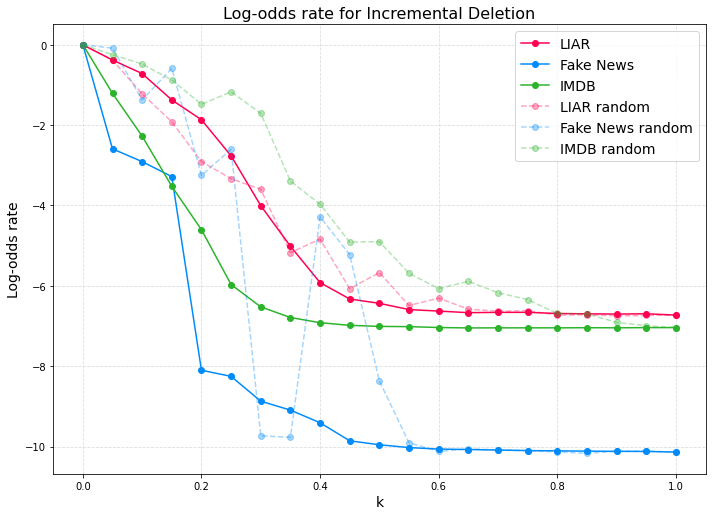

In [ ]:
cols=['lor_change_selected', 'lor_change_rand']
data = [df_inc[ds][col] for col in cols for ds in datasets ]
x = df_inc['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'Log-odds rate'
filename = 'lor_inc.png'
title = 'Log-odds rate for Incremental Deletion'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename, title, xlabel, x,)

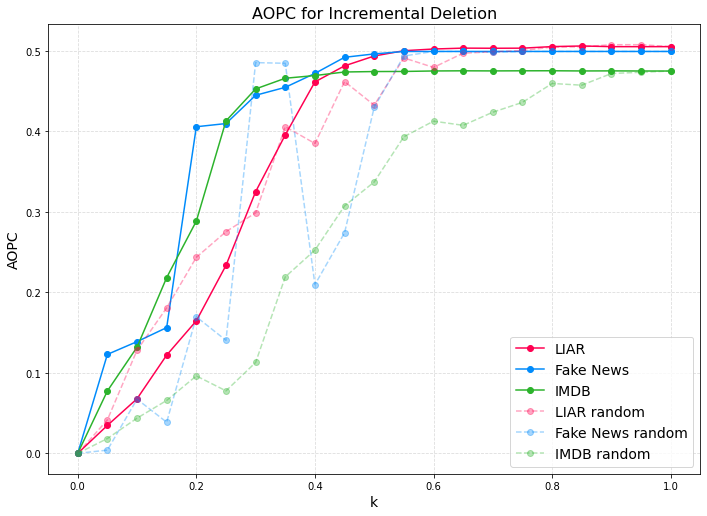

In [ ]:
cols=['aopc_selected', 'aopc_rand']
data = [df_inc[ds][col] for col in cols for ds in datasets ]
x = df_inc['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'AOPC'
filename = 'aopc_inc.png'
title = 'AOPC for Incremental Deletion'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename, title, xlabel, x,)

###inc add

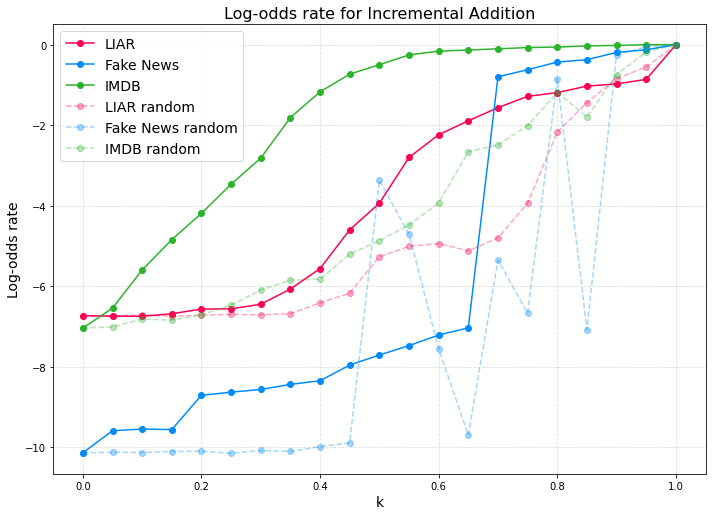

In [ ]:
cols=['lor_change_selected', 'lor_change_rand']
data = [df_inc_add[ds][col] for col in cols for ds in datasets ]
x = df_inc_add['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'Log-odds rate'
filename = 'lor_inc_add.png'
title = 'Log-odds rate for Incremental Addition'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename, title, xlabel, x,)

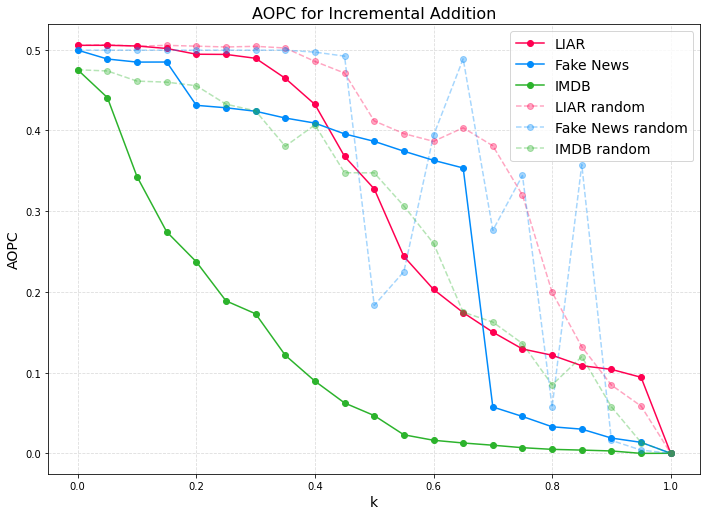

In [ ]:
cols=['aopc_selected', 'aopc_rand']
data = [df_inc_add[ds][col] for col in cols for ds in datasets ]
x = df_inc_add['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB' , 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'AOPC'
filename_del = 'aopc_inc_add.png'
title = 'AOPC for Incremental Addition'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename_del, title, xlabel, x,)

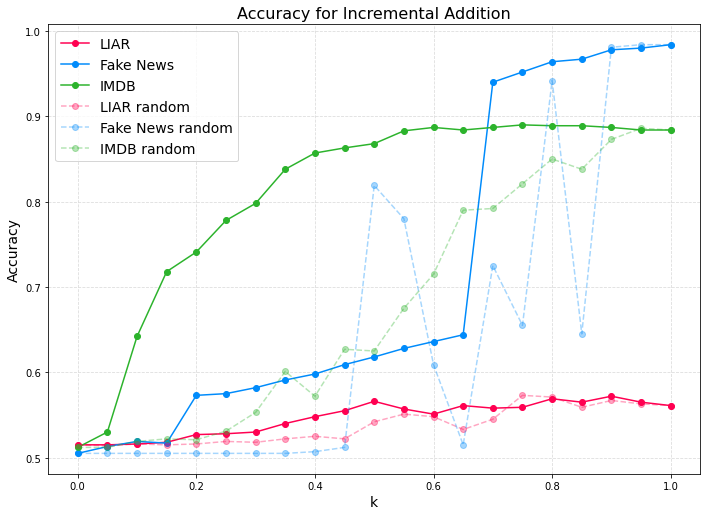

In [ ]:
cols=['acc_selected', 'acc_rand']
data = [df_inc_add[ds][col] for col in cols for ds in datasets ]
x = df_inc_add['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB' , 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'Accuracy'
filename_del = 'aopc_inc_add.png'
title = 'Accuracy for Incremental Addition'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename_del, title, xlabel, x,)

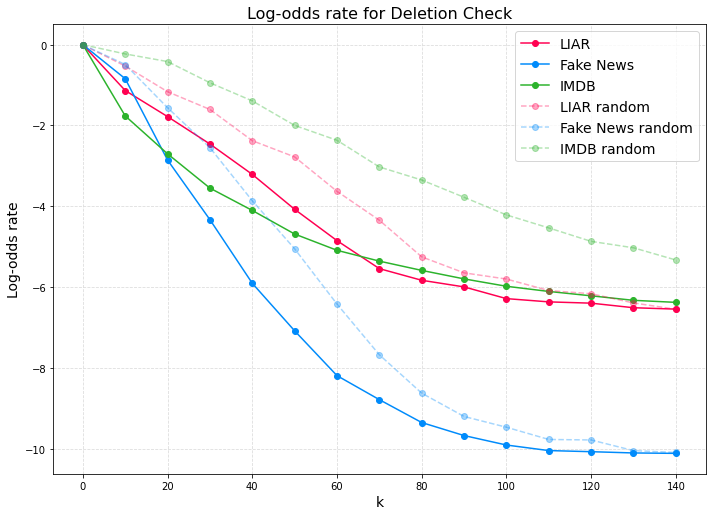

In [ ]:
cols=['lor_change_selected', 'lor_change_rand']
data = [df_del[ds][col]  for col in cols for ds in datasets ]
x = df_del['IMDB']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'Log-odds rate'
filename_del = 'lor_change_selected_del.png'
title = 'Log-odds rate for Deletion Check'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename_del, title, xlabel, x,)

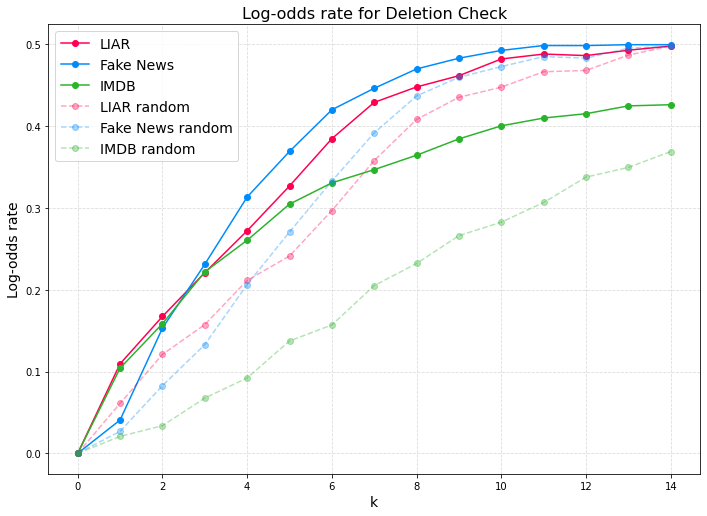

In [ ]:
cols=['aopc_selected', 'aopc_rand']
data = [df_del[ds][col] for col in cols for ds in datasets ]

x = df_del['LIAR']['k']


legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'Log-odds rate'
filename_del = 'lor_change_selected_del.png'
title = 'Log-odds rate for Deletion Check'
xlabel = 'k'

line_plot_template(data, ylabel, legend, filename_del, title, xlabel, x,)



##deletion check


In [ ]:
[print(ds, col)for col in cols for ds in datasets ]

LIAR acc_selected
Fake News acc_selected
IMDB acc_selected
LIAR aopc_rand
Fake News aopc_rand
IMDB aopc_rand


[None, None, None, None, None, None]

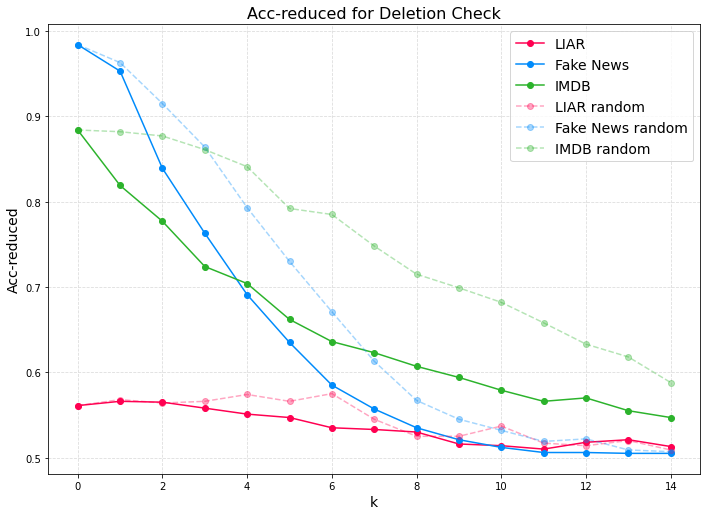

In [ ]:
cols=['acc_selected', 'acc_rand']
data = [df_del[ds][col] for col in cols for ds in datasets ]
x = df_del['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'Acc-reduced'
filename = 'acc_del.png'
title = 'Acc-reduced for Deletion Check'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename, title, xlabel, x,)

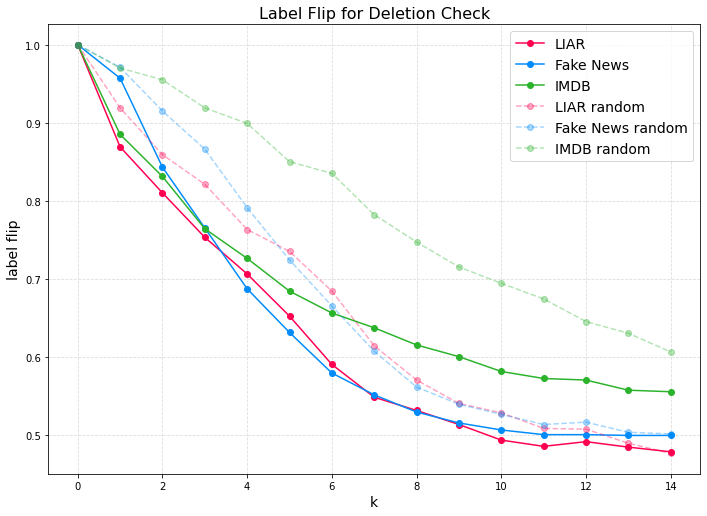

In [ ]:
cols=['flip_selected', 'flip_rand']
data = [df_del[ds][col] for col in cols for ds in datasets ]
x = df_del['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'label flip'
filename = 'fip_del.png'
title = 'Label Flip for Deletion Check'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename, title, xlabel, x,)

###pres check

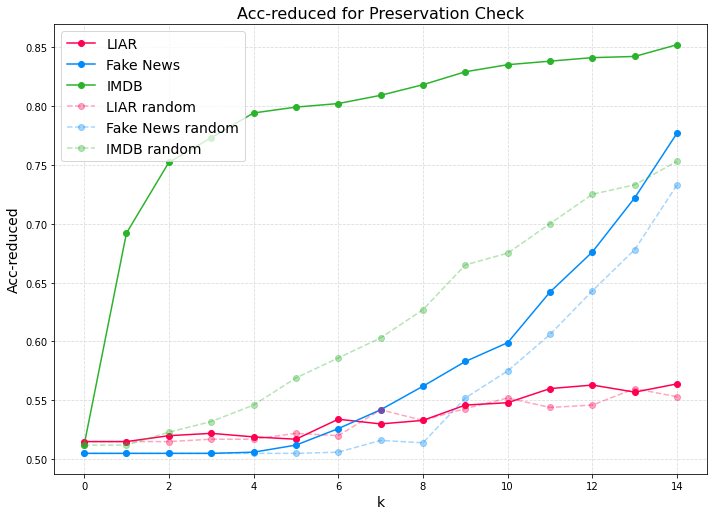

In [ ]:
cols=['acc_selected', 'acc_rand']
data = [df_pres[ds][col] for col in cols for ds in datasets ]
x = df_pres['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'Acc-reduced'
filename = 'acc_pres.png'
title = 'Acc-reduced for Preservation Check'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename, title, xlabel, x,)

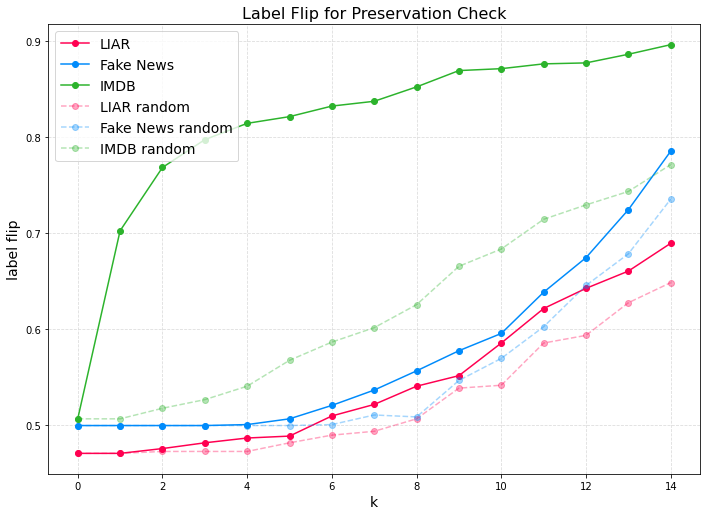

In [ ]:
cols=['flip_selected', 'flip_rand']
data = [df_pres[ds][col] for col in cols for ds in datasets ]
x = df_pres['LIAR']['k']
legend = ['LIAR', 'Fake News', 'IMDB', 'LIAR random', 'Fake News random', 'IMDB random']
ylabel = 'label flip'
filename = 'flip_pres.png'
title = 'Label Flip for Preservation Check'
xlabel = 'k'
line_plot_template(data, ylabel, legend, filename, title, xlabel, x,)

#shap

In [ ]:
%%capture
!pip install shap

In [ ]:
import shap
import pickle
import numpy as np
import pandas as pd
import random
import torch


In [ ]:
path='/content/drive/MyDrive/fake-news-adversarial-benchmark/'

# Define paths liar

dataset='LIAR'
model_path = path+'Model/liar_model2'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/liar/'
path_csv= path_data_created+'liar_1000.csv'
shap_path=path_data_created+'shapvalues_1000_liar.sav'
path_labels=path_data_created+'labels_liar.npy'
outputs_path=path_data_created+'original_probs_liar_1000.pt'

# Define paths Fake News

dataset='Fake News'
model_path = path+'Model/fn_model'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/fake_news/'
path_csv= path_data_created+'fake_news_1000.csv'
path_labels=path_data_created+'labels_fake_news.npy'
shap_path=path_data_created+'shapvalues_1000_fake_news.sav'
outputs_path=path_data_created+'original_outputs_fake_news_1000.pt'

# Define paths imdb

dataset='IMDB'
path_data_created='/content/drive/MyDrive/fake-news-adversarial-benchmark/data_created/imdb/'
path_csv= path_data_created+'imdb_1000.csv'
path_labels=path_data_created+'labels_imdb.npy'
shap_path=path_data_created+'shapvalues_1000_imdb.sav'
outputs_path=path_data_created+'original_probs_imdb_1000.pt'
"""


SyntaxError: ignored

In [ ]:
shap_values = pickle.load(open(shap_path, 'rb'))

In [ ]:
path_final=path+'final_files/'+dataset+'/'

df = pd.read_csv(path_csv)
labels = np.load(path_labels)
shap_values = pickle.load(open(shap_path, 'rb'))
original_probs= torch.load(outputs_path, map_location=torch.device('cpu'))
labels=torch.LongTensor(labels)

In [ ]:
df.head()

In [ ]:
np.random.seed(42)
rand_index= np.random.randint(0, high=1000, size=5)

In [ ]:
shap_values[rand_index[0]]

.values =
array([ 0.        ,  0.00490105,  0.00268453,  0.00688738,  0.00365818,
        0.00770843,  0.0048399 ,  0.00829434,  0.0130564 ,  0.00249624,
        0.00745153,  0.0097388 ,  0.00669724, -0.00151104, -0.00126433,
       -0.00331485,  0.        ])

.base_values =
10.309349060058594

.data =
array(['', ' 20', ' wines', ' for', ' under', ' $', ' 20', ' :', ' the',
       ' fall', ' edition', ' -', ' the', ' new', ' york', ' times', ''],
      dtype='<U8')

In [ ]:
df = pd.read_csv(path_csv)

sample = df.loc[rand_index].copy()
#with pd.option_context("max_colwidth", 1000):
 #   print (sample.to_latex(path_data_created+dataset+'_sample.tex'))

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
print(tokenizer(sample.iloc[

]['statement'])['input_ids'])
print(shap_values[rand_index[]].data)

In [ ]:
# Load the tokenizer and model

if dataset == 'IMDB':
  print('Using IMDB trained model and Tokenizer')
  !pip install textattack
  from transformers import AutoModelForSequenceClassification, AutoTokenizer
  tokenizer = AutoTokenizer.from_pretrained("textattack/bert-base-uncased-imdb")
  model = AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-imdb")
else:
  print('Using '+str(model_path)+' model')
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  model = BertForSequenceClassification.from_pretrained(model_path,  num_labels = 2)



##SHAP graphs

In [ ]:
shap.plots.bar(shap_values.abs.mean(0), show = False)
plt.title("IMDB Global Top Features", fontsize=14)
plt.xlabel("mean absolute shap values per feature", fontsize=14)
plt.rcParams["font.family"] = "Arial"
plt.gcf().set_size_inches(11.69, 8.27)
plt.savefig((path_data_created+dataset+'global_shap.png'), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print(dataset)
shap.plots.text(shap_values[rand_index[0]])
